## What is nonogram?

Nonograms, also known as Hanjie, Paint by Numbers, Picross, Griddlers, and Pic-a-Pix are picture logic puzzles in which cells in a grid must be colored or left blank according to numbers at the edges of the grid to reveal a hidden picture. In this puzzle, the numbers are a form of discrete tomography that measures how many unbroken lines of filled-in squares there are in any given row or column. For example, a clue of "4 8 3" would mean there are sets of four, eight, and three filled squares, in that order, with at least one blank square between successive sets.

These puzzles are often black and white—describing a binary image—but they can also be colored. If colored, the number clues are also colored to indicate the color of the squares. Two differently colored numbers may or may not have a space in between them. For example, a black four followed by a red two could mean four black boxes, some empty spaces, and two red boxes, or it could simply mean four black boxes followed immediately by two red ones. Nonograms have no theoretical limits on size, and are not restricted to square layouts.

Nonograms were named after Non Ishida, one of the two inventors of the puzzle.

- Example image

![example.png](nonogram_example.png)

Solving nonogram puzzles is an NP-complete problem. This means that there is no polynomial time algorithm that solves all nonogram puzzles unless P = NP.

\- Source: Wikipedia


### But if we use quantum computers, we can always solve any nonogram in polynomial time.

## Qiskit Installation and library Import

In [ ]:
%pip install qiskit
%pip install qiskit_aer
%pip install pylatexenc

In [5]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import *

# Importing Numpy
import numpy as np

# Quantum simulator
from qiskit_aer import Aer
from qiskit.circuit.library import MCXGate

### 1. Nonogram row/column check algorithm

Let's encode the black square to 1 and the white squre to 0. Then we can encode any nonogram pattern to binary image.

- Example <br><br>
![example_2.png](nonogram_example_2.png)
<br> 0 0 0 0 0 0 0 0 <br> 0 1 1 1 1 0 0 0 <br> 0 1 1 1 1 1 1 0 <br> 0 1 1 0 0 1 1 0 <br> 0 1 1 0 0 1 1 0 <br> 0 1 1 1 1 1 1 0 <br> 0 1 1 1 1 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 0 0 0 0 0 0 0

Because the number of nxm nonogram patterns is 2^(nxm), classical computer cannot solve the nonogram problem in polynomial time. But quantum computer can input the superposed state, we can encode all nxm nonogram in (nxm) qubits.

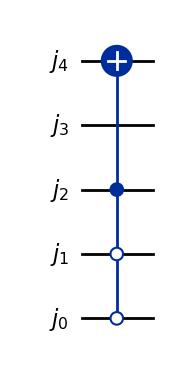

In [11]:
qr = QuantumRegister(5, name='j')
qc_test = QuantumCircuit(qr)
qc_test.append(MCXGate(3, ctrl_state="010"), [1, 2, 0, 4])

qc_test.draw(output="mpl", reverse_bits=True)